In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt

class ShapesDataset(Dataset):
    def __init__(self, num_images, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - num_images: Integer specifying the number of images in the dataset.
        - transform: Optional torchvision transforms to apply to the images.
        """
        self.num_images = num_images
        self.shapes = ['triangle', 'circle', 'square']
        self.canvas_size = 64
        self.transform = transform
        self.shape_to_idx = {'triangle': 0, 'circle': 1, 'square': 2}
        self.idx_to_shape = {0: 'triangle', 1: 'circle', 2: 'square'}
        self.radius = 8

        # Spatial relationship phrases for variety
        self.spatial_phrases = {
            'upper_left': ['to the upper left of', 'above and to the left of', 'diagonally up and left from'],
            'upper_right': ['to the upper right of', 'above and to the right of', 'diagonally up and right from'],
            'lower_left': ['to the lower left of', 'below and to the left of', 'diagonally down and left from'],
            'lower_right': ['to the lower right of', 'below and to the right of', 'diagonally down and right from'],
            'above': ['above', 'directly above', 'higher than'],
            'below': ['below', 'directly below', 'lower than'],
            'left': ['to the left of', 'left of'],
            'right': ['to the right of', 'right of']
        }

    def generate_caption(self, shape1_idx, shape2_idx, loc1, loc2):
        """
        Generates a natural language caption describing the spatial relationship between two shapes.
        
        Parameters:
        - shape1_idx: Index of first shape
        - shape2_idx: Index of second shape
        - loc1: Coordinates of first shape (x, y)
        - loc2: Coordinates of second shape (x, y)
        
        Returns:
        - string: A natural language caption describing the scene
        """
        # Get shape names
        shape1_name = self.idx_to_shape[shape1_idx]
        shape2_name = self.idx_to_shape[shape2_idx]
        
        # Get coordinates
        x1, y1 = loc1
        x2, y2 = loc2
        
        # Calculate position differences
        dx = x1 - x2  # Positive means shape1 is to the right
        dy = y1 - y2  # Positive means shape1 is lower
        
        # Define thresholds for "directly" above/below/left/right
        threshold = 5  # pixels
        
        # Determine spatial relationship
        if abs(dx) <= threshold:  # Roughly aligned vertically
            if dy < 0:
                relation = random.choice(self.spatial_phrases['above'])
            else:
                relation = random.choice(self.spatial_phrases['below'])
        elif abs(dy) <= threshold:  # Roughly aligned horizontally
            if dx < 0:
                relation = random.choice(self.spatial_phrases['left'])
            else:
                relation = random.choice(self.spatial_phrases['right'])
        else:  # Diagonal relationship
            if dx < 0 and dy < 0:
                relation = random.choice(self.spatial_phrases['upper_left'])
            elif dx < 0 and dy > 0:
                relation = random.choice(self.spatial_phrases['lower_left'])
            elif dx > 0 and dy < 0:
                relation = random.choice(self.spatial_phrases['upper_right'])
            else:  # dx > 0 and dy > 0
                relation = random.choice(self.spatial_phrases['lower_right'])
        
        # Construct caption
        caption = f"{shape1_name} is {relation} {shape2_name}"
        return caption

    def __len__(self):
        return self.num_images

    def draw_shape_on_image(self, img, shape, location, color='black'):
        """
        Draws a specified shape at a given location on the provided image.

        Parameters:
        - img: PIL Image object to draw on.
        - shape: String specifying the shape ('triangle', 'circle', 'square').
        - location: Tuple (x, y) specifying the location of the shape's center.

        Returns:
        - img: PIL Image object with the shape drawn on it.
        """
        draw = ImageDraw.Draw(img)
        x, y = location

        if shape == 'circle':
            r = self.radius  # Radius
            leftUpPoint = (x - r, y - r)
            rightDownPoint = (x + r, y + r)
            draw.ellipse([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'square':
            s = self.radius * 2  # Side length
            leftUpPoint = (x - s // 2, y - s // 2)
            rightDownPoint = (x + s // 2, y + s // 2)
            draw.rectangle([leftUpPoint, rightDownPoint], fill=color)

        elif shape == 'triangle':
            s = self.radius * 2  # Side length
            h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
            point1 = (x, y - h / 3)
            point2 = (x - s / 2, y + h * 2 / 3)
            point3 = (x + s / 2, y + h * 2 / 3)
            draw.polygon([point1, point2, point3], fill=color)

        else:
            raise ValueError("Shape must be 'triangle', 'circle', or 'square'.")

        return img

    def __getitem__(self, idx):
        """
        Generates one image and its labels.

        Parameters:
        - idx: Index of the image (not used as images are generated on-the-fly).

        Returns:
        - img: Tensor representing the image.
        - labels: Dictionary containing the shapes and locations of the objects.
        """
        # Create a blank image
        img = Image.new('RGB', (self.canvas_size, self.canvas_size), 'gray')

        # Randomly select two shapes, make sure they are different
        shape1 = random.choice(self.shapes)
        while True:
            shape2 = random.choice(self.shapes)
            if shape1 != shape2:
                break

        # Randomly select locations
        x1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y1 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        x2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)
        y2 = random.randint(self.radius + 1, self.canvas_size - self.radius - 1)

        # Randomly decide drawing order to allow overlapping
        if random.random() < 0.5:
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            shapes_order = [shape1, shape2]
            locations_order = [(x1, y1), (x2, y2)]
        else:
            img = self.draw_shape_on_image(img, shape2, (x2, y2), color="blue")
            img = self.draw_shape_on_image(img, shape1, (x1, y1), color="red")
            shapes_order = [shape2, shape1]
            locations_order = [(x2, y2), (x1, y1)]

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Encode labels and generate caption
        shape1_idx = self.shape_to_idx[shapes_order[0]]
        shape2_idx = self.shape_to_idx[shapes_order[1]]
        location1 = torch.tensor(locations_order[0], dtype=torch.float32)
        location2 = torch.tensor(locations_order[1], dtype=torch.float32)
        
        caption = self.generate_caption(shape1_idx, shape2_idx, locations_order[0], locations_order[1])

        labels = {
            'shape1': shape1_idx,
            'location1': location1,
            'shape2': shape2_idx,
            'location2': location2,
            'caption': caption
        }

        return img, labels


Images batch shape: torch.Size([16, 3, 64, 64])
Labels batch: {'shape1': tensor([2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 1, 0, 1, 1, 2]), 'location1': tensor([[20., 18.],
        [21., 31.],
        [16., 33.],
        [34., 24.],
        [51., 33.],
        [55., 11.],
        [24., 35.],
        [26., 31.],
        [19., 53.],
        [14., 37.],
        [49., 16.],
        [45., 24.],
        [41., 45.],
        [27., 12.],
        [27., 26.],
        [11., 42.]]), 'shape2': tensor([1, 2, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 1]), 'location2': tensor([[33., 38.],
        [44., 44.],
        [38., 42.],
        [18., 51.],
        [43., 45.],
        [45., 24.],
        [45., 38.],
        [24., 36.],
        [17., 49.],
        [25., 22.],
        [52., 10.],
        [51., 53.],
        [52., 31.],
        [47., 52.],
        [20., 15.],
        [27., 51.]]), 'caption': ['square is to the upper left of circle', 'triangle is to the upper left of square', 'square is diagonally up and left f

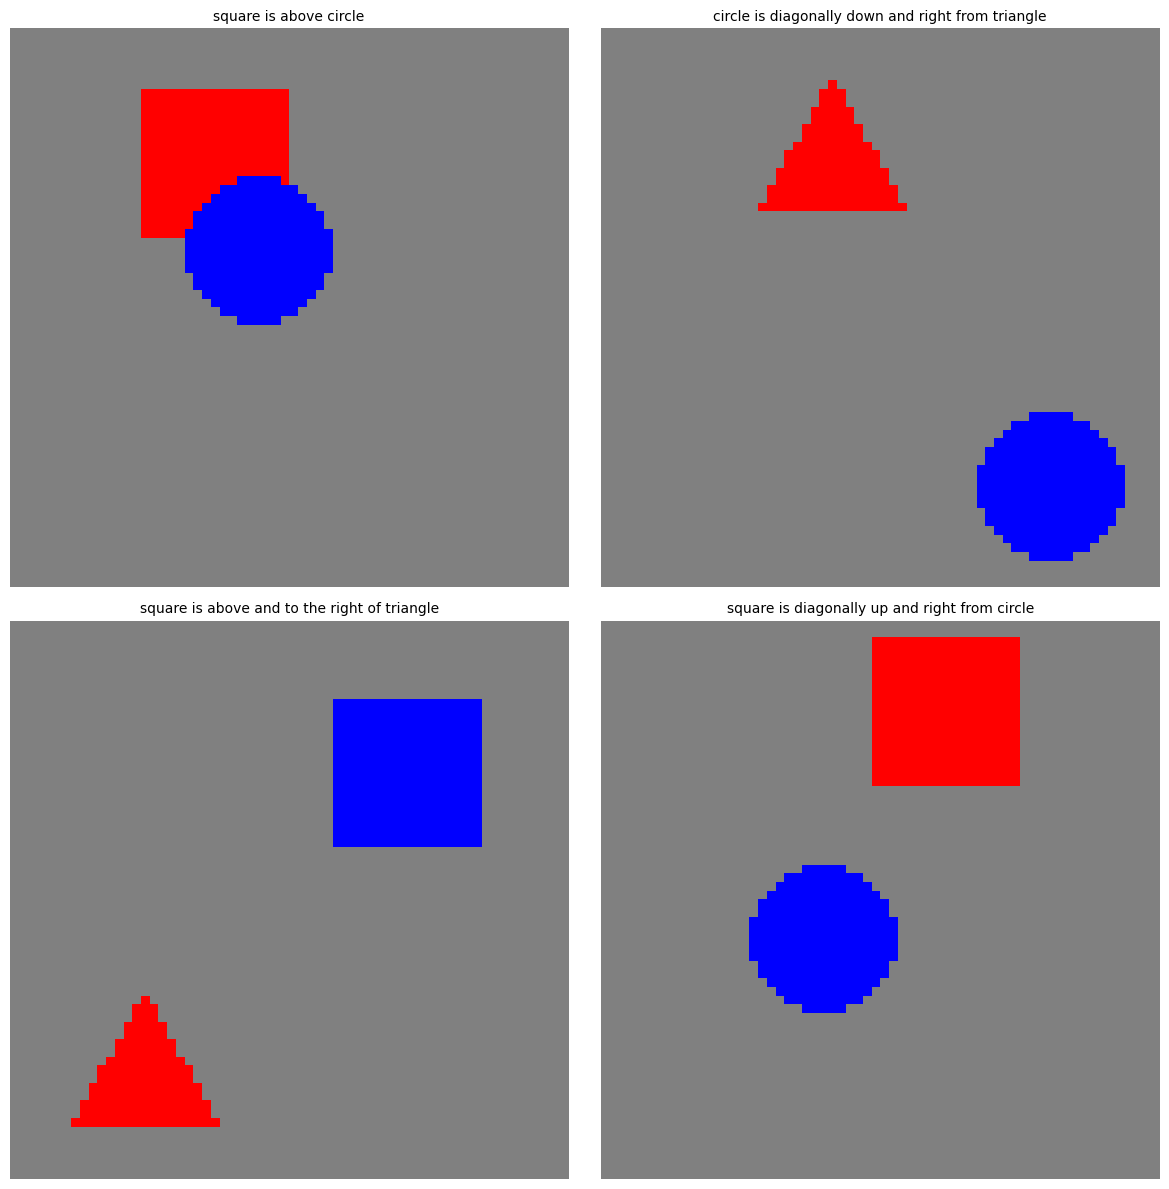

In [7]:

# Example usage:
if __name__ == '__main__':
    # Define any transforms (optional)
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Add more transforms if needed
    ])
    # Create the dataset
    dataset = ShapesDataset(num_images=1000, transform=transform)
    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Iterate over the DataLoader
    for images, labels in dataloader:
        print(f"Images batch shape: {images.size()}")
        print(f"Labels batch: {labels}")
        print("Sample of batch captions:")
        # Print first 3 captions from batch
        for i in range(min(3, len(images))):
            print(f"Image {i}: {labels['caption'][i]}")
        break

    # Display multiple images with captions
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(4):
        img, lbl = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        
        # Plot image
        axes[i].imshow(img_np)
        axes[i].set_title(f"{lbl['caption']}", fontsize=10, wrap=True)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transforms if needed
])
# Create the dataset
dataset = ShapesDataset(num_images=10000, transform=transform)
# sample 10000 images and save the images and labels as tensors
images = []
labels = []
for i in range(10000):
    img, lbl = dataset[i]
    images.append(img)
    labels.append(lbl)
    
image_tensors = torch.stack(images)
print(image_tensors.mean())
print(image_tensors.std())

tensor(0.4849)
tensor(0.1583)


In [36]:
shape1 = torch.tensor([item['shape1'] for item in labels], dtype=torch.long)
location1 = torch.stack([item['location1'] for item in labels], dim=0)
shape2 = torch.tensor([item['shape2'] for item in labels], dtype=torch.long)
location2 = torch.stack([item['location2'] for item in labels], dim=0)

In [37]:
from torch.utils.data import TensorDataset
dataset = TensorDataset(image_tensors, shape1, location1, shape2, location2)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
batch = next(iter(dataloader))

In [42]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation

ls: cannot access '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation': No such file or directory


In [43]:
!mkdir /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation

In [45]:
import os
from os.path import join
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation"
os.makedirs(join(savedir, "dataset"), exist_ok=True)
torch.save({"images": image_tensors, "shape1": shape1, "location1": location1, "shape2": shape2, "location2": location2}, 
           join(savedir, "dataset", "shapes_dataset_pilot.pth"))

In [50]:
class ShapesDatasetCached(Dataset):
    filename = "shapes_dataset_pilot.pth"
    savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Diffusion_ObjectRelation"
    def __init__(self, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - transform: Optional torchvision transforms to apply to the images.
        """
        self.transform = transform
        self.data = torch.load(join(self.savedir, "dataset", self.filename))
        self.images = self.data["images"]
        self.shape1 = self.data["shape1"]
        self.location1 = self.data["location1"]
        self.shape2 = self.data["shape2"]
        self.location2 = self.data["location2"]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        shape1 = self.shape1[idx]
        location1 = self.location1[idx]
        shape2 = self.shape2[idx]
        location2 = self.location2[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, (shape1, location1, shape2, location2)
    
dataset2 = ShapesDatasetCached(transform=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))

In [51]:
dataset2[0][0]

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

In [39]:
image_tensors.shape

torch.Size([10000, 3, 64, 64])